# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

from sklearn.linear_model import LinearRegression

## 1.1. Zones

In [2]:
zones = U.load(DATA / 'zones/in_2020.parquet',
               columns='geoid scale county urba geometry'.split(),
               filters=[('aland', '>', 0)]).disp(0)

7,072 rows x 5 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,geometry
,<object>,<category>,<category>,<category>,<geometry>


## 1.2. SES

In [3]:
ses = (U.load(DATA / 'ses/ses.parquet').merge(zones['geoid'])
       .drop_duplicates(subset=['geoid'])).disp()

7,052 rows x 33 cols; Memory: 1.8 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_loweng,...,p_nowfh,p_transit,p_walkbike,svi,svi_ses,svi_hh,svi_race,svi_trans,adi_nat,sedi
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,County,35685.0,35107.0,15842.0,105.288811,103.58342,0.224996,0.047527,0.0136,...,0.950636,0.006758,0.025171,0.598,0.6712,0.3307,0.1903,0.7982,0.716667,0.561776


## 1.3. Accessibility

In [4]:
xs = U.load(DATA / 'access/access/indiana.parquet')
purp = xs.pop('purpose').map({'Work': ' jobs', 'Non-work': ' POIs'})
xs.kind = (xs.kind.astype(str) + purp.astype(str)).astype(CAT)
xs.disp(); pass

3,166,152 rows x 7 cols; Memory: 33.9 MiB


,measure,kind,mode,thresh,scale,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>
0,Contour,All jobs,Bike,15,BG,180010301001,90.0


In [5]:
xs_max = U.load(DATA / 'access/access/indiana_max.parquet').disp(0)

3,496,399 rows x 8 cols; Memory: 40.7 MiB


,measure,purpose,kind,mode,thresh,scale,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float32>


# 2. Visualize

In [8]:
def plot_IN(df, var, ax=None, zones=zones, fill=False,
            rank=False, title=None, **kwargs):
    df = zones[['geoid', 'geometry']].merge(df, 'left')
    if fill: df[var] = df[var].fillna(0)
    if rank: df[var] = df[var].rank(pct=True)
    ax = ax or U.plot(size=(6, 12), dpi=150, axoff=1, title=title)
    U.maplot(df, var, ax, basemap=None, **kwargs)
    U.filt(zones, scale='County').plot(ax=ax, fc='none', ec='k', lw=0.5)

## 2.1. All Indiana maps

In [17]:
def fig_xs_unique(query: dict, xs=xs, cmap='rainbow_r',
                  rank=True, show=True, save=False, **kwargs):
    df = U.filt(xs, **query)
    if len(df) == 0: return
    if rank: df.access = df.access.rank(pct=True)
    title = '\n'.join([f'{k}={v}' for k, v in query.items()])
    ax = U.plot(size=(6, 12), axoff=1, title=title)
    label = 'Access' + (' quantile' if rank else '')
    plot_IN(df, 'access', ax=ax, cmap=cmap, label=label,
            shrink=0.4, **kwargs)
    if save:
        outpath = 'fig/indiana/combinations'
        U.imsave(title.replace('\n', ''), dpi=150, root=outpath)
    if not show: plt.close()

# fig_xs_unique(D(scale='Tract', mode='Drive', measure='Gravity',
#                 kind='All jobs', thresh='45'))

In [12]:
def save_fig_xs_unique(*args, **kw):
    fig_xs_unique(*args, save=True, show=False, **kw)
    
grp_cols = ['kind', 'scale', 'measure', 'mode', 'thresh']
combs = [D(zip(grp_cols, x)) for x in it.product(
    *[xs[var].cat.categories for var in grp_cols])]
# pqdm(combs, save_fig_xs_unique, n_jobs=36); # 1m28s

## 2.2. Comparing measures

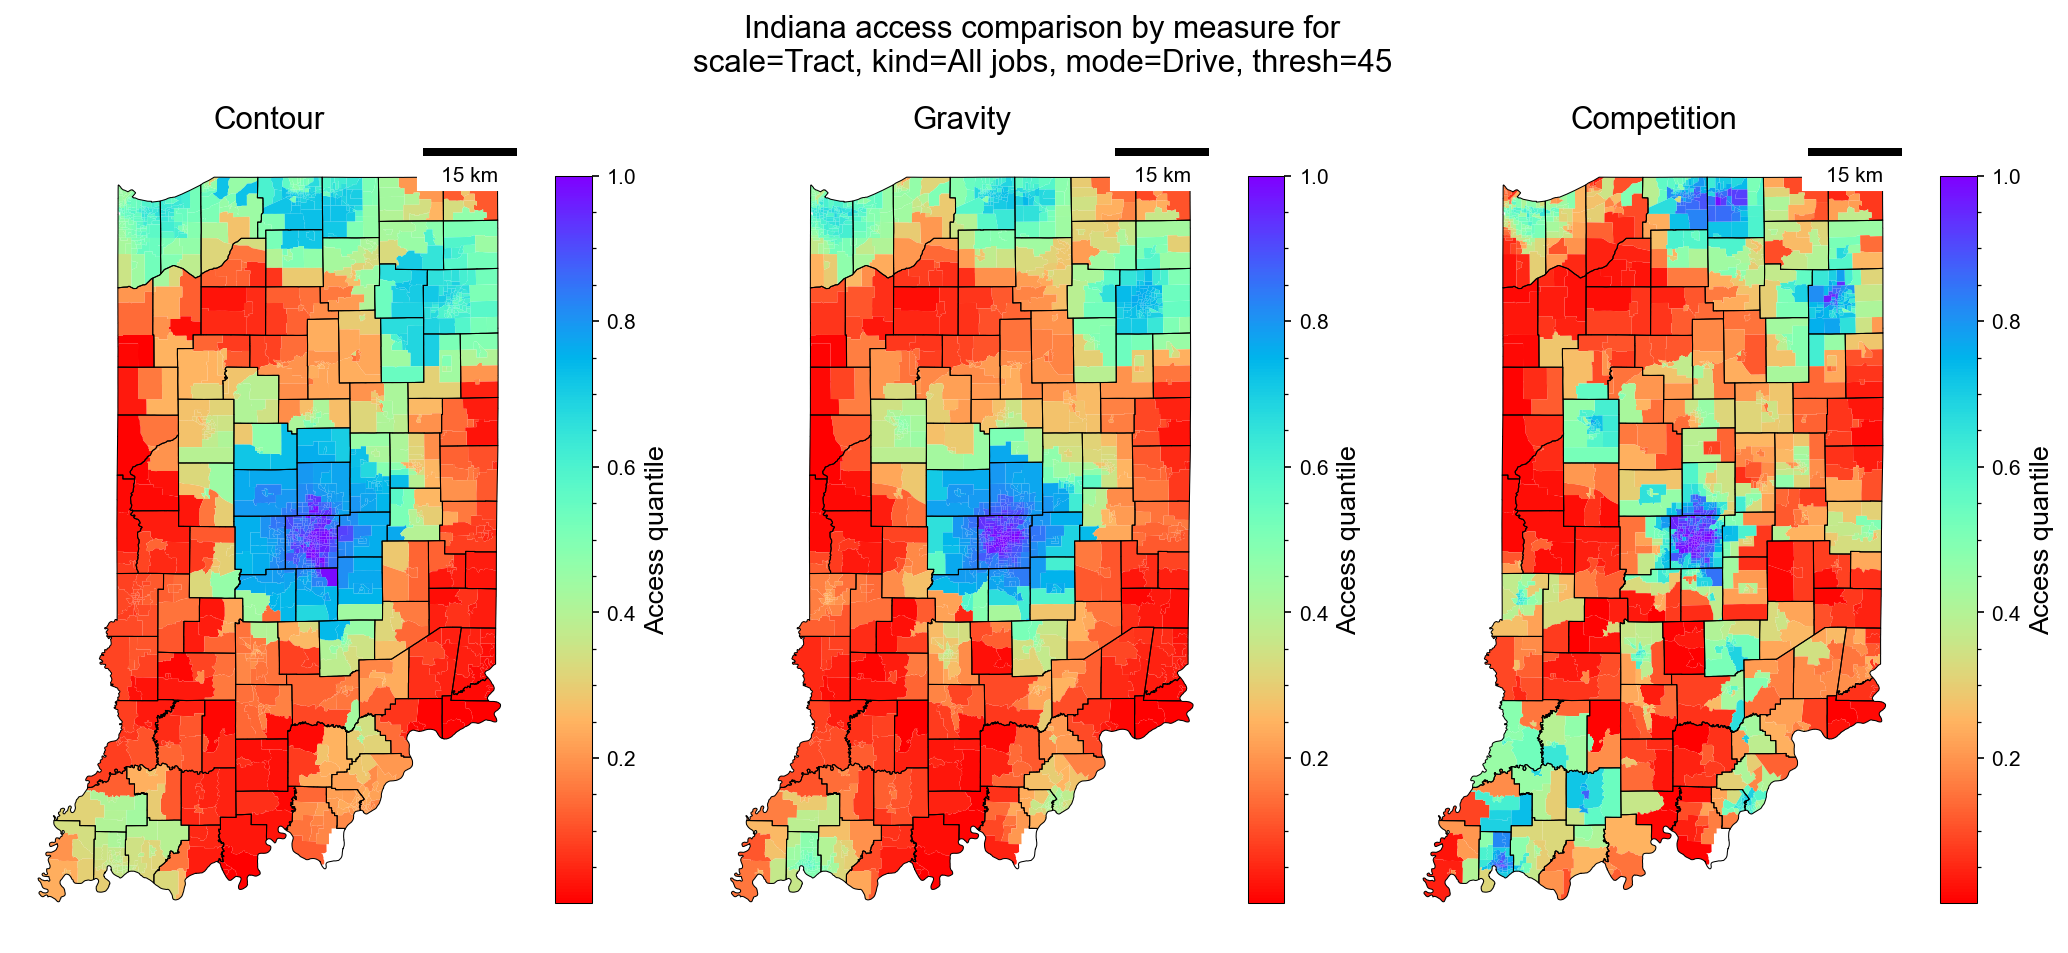

In [13]:
def fig_xs_by_measure(query: dict, rank=True, xs=xs, cmap='rainbow_r'):
    _, axes = plt.subplots(1, 3, figsize=(14, 10), dpi=150)
    for i, measure in enumerate(['Contour', 'Gravity', 'Competition']):
        df = U.filt(xs, measure=measure, **query)
        if rank: df.access = df.access.rank(pct=True)
        ax = U.plot(axes[i], axoff=1, title=measure)
        plot_IN(df, 'access', ax=ax, cmap=cmap, label='Access quantile')
    title = ('Indiana access comparison by measure for\n' +
             ', '.join([f'{k}={v}' for k, v in query.items()]))
    plt.tight_layout()
    plt.suptitle(title, y=0.85)
    U.imsave('Access comparison of measurement model')

fig_xs_by_measure(D(scale='Tract', kind='All jobs', mode='Drive', thresh='45')) # 4s

In [12]:
# for th in tqdm([15, 30, 45, 60, 90]):
#     fig_xs_by_measure(D(scale='Tract', kind='All jobs', mode='Drive', thresh=str(th)))

## 2.3. Access vs urbanity

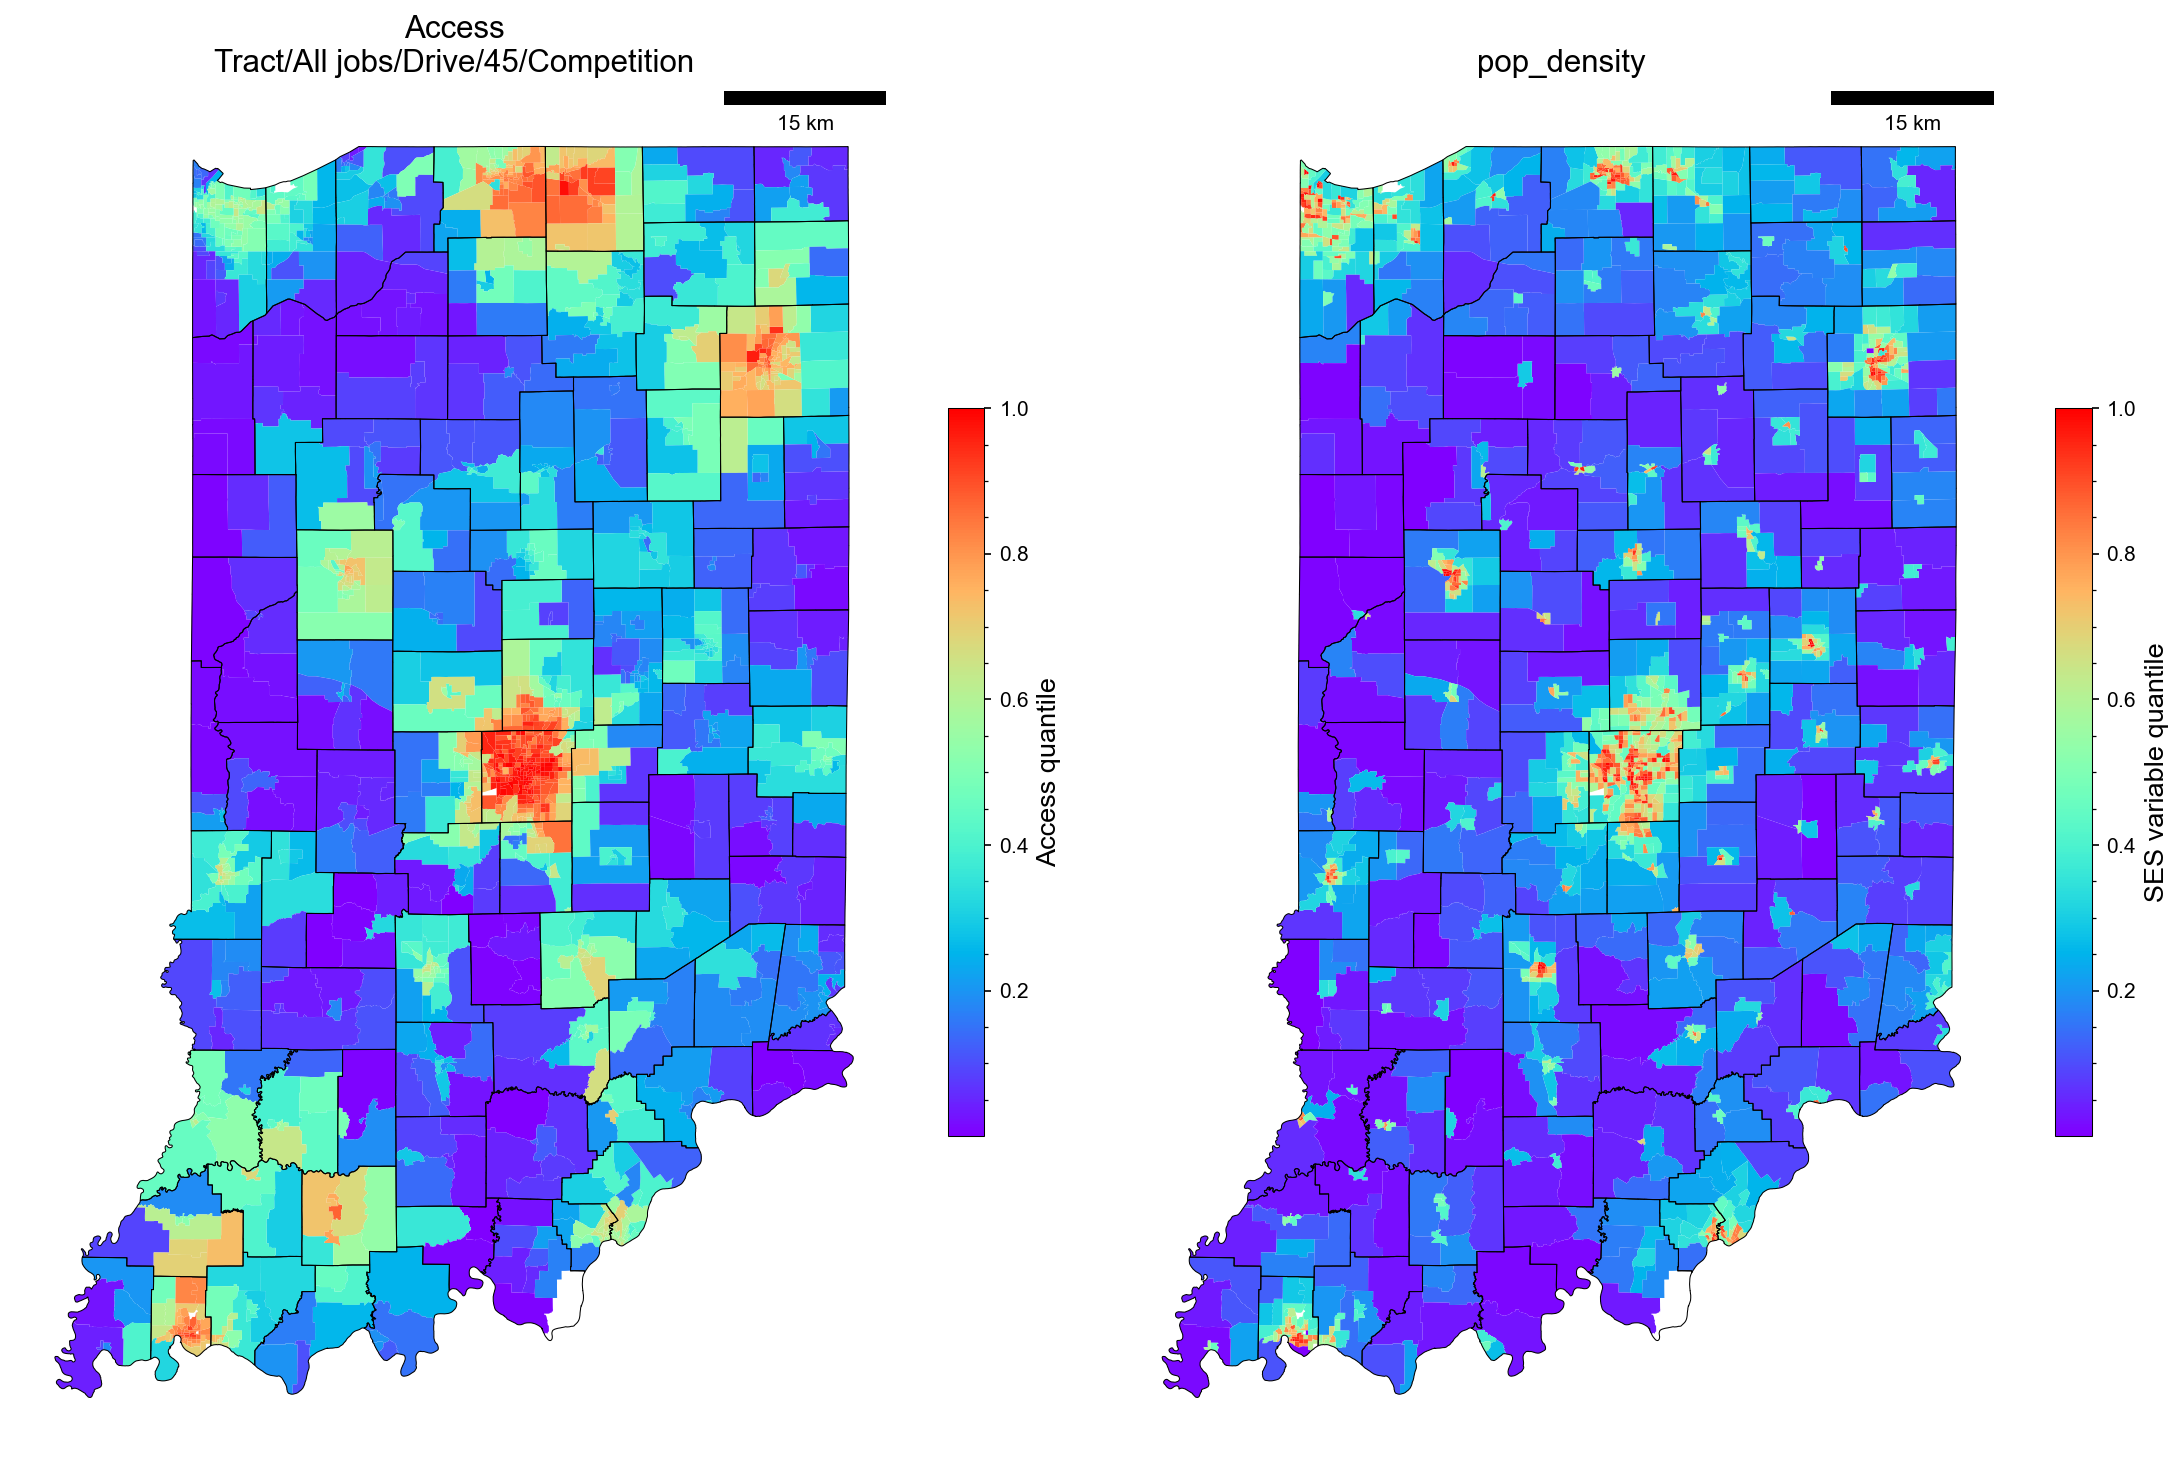

In [19]:
def fig_xs_vs_ses(ses_col, xs_kws={}, rank=True,
                  xs=xs, ses=ses, size=(15, 10), dpi=150):
    xs_kws = D(scale='Tract', kind='All jobs', mode='Drive',
               thresh='45', measure='Competition') | xs_kws
    df = U.filt(xs, **xs_kws).merge(ses[['geoid', ses_col]])
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    title = 'Access\n' + '/'.join(xs_kws.values())
    ax = U.plot(axes[0], axoff=1, title=title)
    plot_IN(df, 'access', ax, rank=rank, label='Access quantile')
    ax = U.plot(axes[1], axoff=1, title=ses_col)
    plot_IN(df, ses_col, ax, rank=rank, label='SES variable quantile')
    plt.tight_layout()

fig_xs_vs_ses('pop_density')

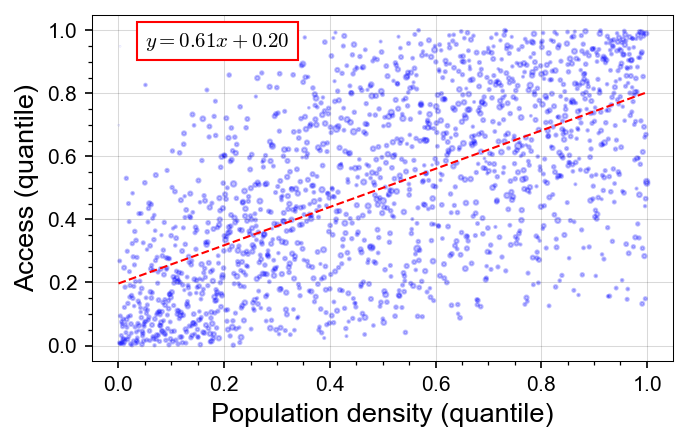

In [20]:
df = (U.filt(xs, scale='Tract', mode='Drive', kind='All jobs',
             thresh='45', measure='Competition')
      .merge(U.filt(ses, scale='Tract')[['geoid', 'popu', 'pop_density']]))
for col in ['pop_density', 'access']:
    df[col] = df[col].rank(pct=True)
ax = U.plot(size=(5, 3), ylab='Access (quantile)',
            xlab='Population density (quantile)')
ax.scatter(df.pop_density, df.access, alpha=0.25, color='b',
           s=10 * U.normalize(df.popu))
reg = LinearRegression().fit(df[['pop_density']], df['access'])
m, c = reg.coef_[0], reg.intercept_
x = np.linspace(0, 1, 100)
ax.plot(x, m * x + c, ls='--', color='r', lw=1)
ax.text(0.05, 0.95, '$y=%.2f x + %.2f$' % (m, c), bbox=D(fc='w', ec='r'));

## 2.4. Modal access gap

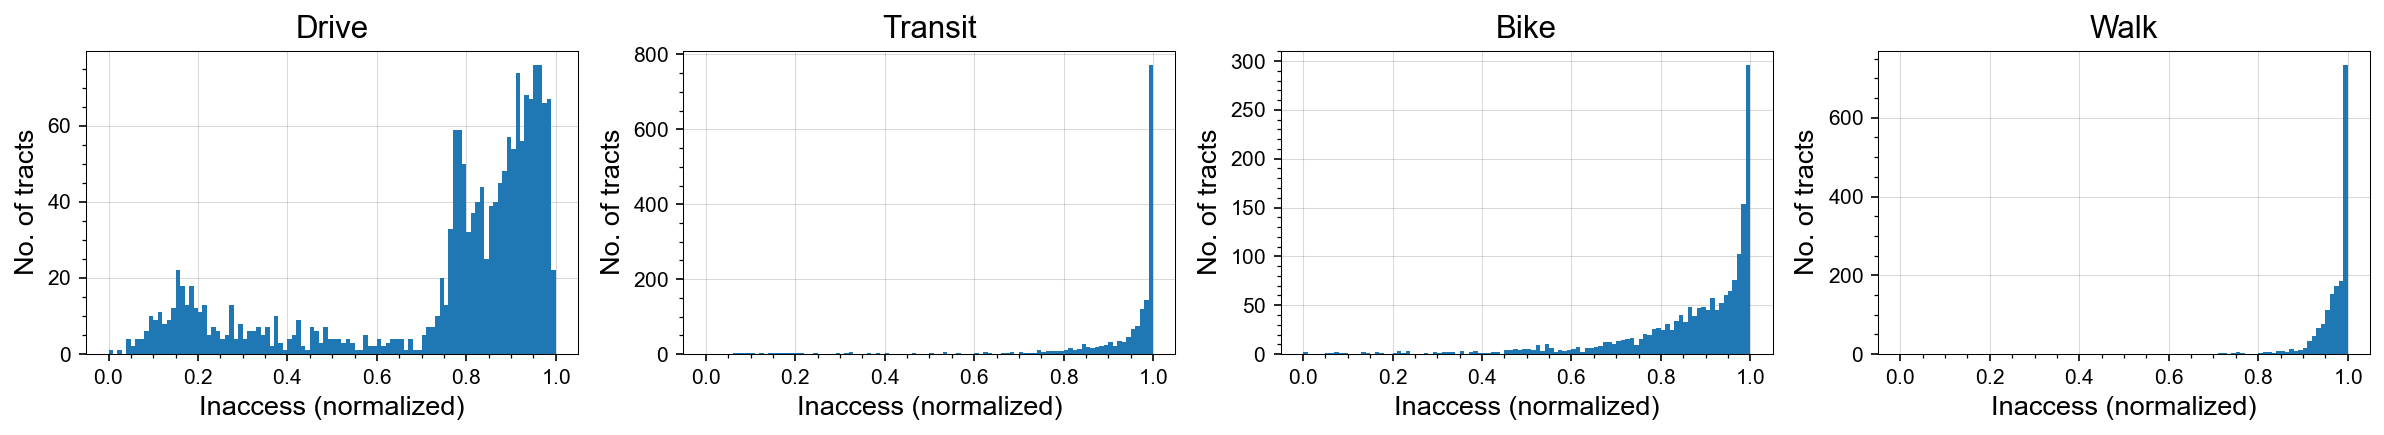

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(16, 3), dpi=150)
for i, mode in enumerate(['drive', 'transit', 'bike', 'walk']):
    ax = U.plot(axes[i], title=mode.title(), ylab='No. of tracts', xlab='Inaccess (normalized)')
    xs[xs.geoid.str.len()==11][f'x_{mode}'].hist(ax=ax, bins=100)
plt.tight_layout()

## 2.5. Flat cutoff vs decay

In [ ]:
def get_flat_vs_decay():
    return xs

x = get_flat_vs_decay(); x

In [13]:
def get_flat_vs_decay(level, rgn, kind, mode, thresh, 
                      opport=opport, params=imped_params):
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0].alpha, params.iloc[0].beta
    tt = pd.read_parquet(DATA / 'od_cost/osrm/{}/{}/bg_{}_2020.parquet'
                         .format(level, rgn, mode), filters=[
                             ('duration', '<=', thresh * 60)])
    tt['decay'] = np.exp(-alpha * (tt.duration / 60) ** beta)
    df = opport.query(f'kind=="{kind}"')[['geoid', 'opport']]
    wt = tt.assign(flat=1).merge(df, left_on='trg_geoid', right_on='geoid')
    for col in ['flat', 'decay']: wt[col] *= wt['opport']
    xs = (wt.groupby('src_geoid')[['flat', 'decay']].sum()
          .rename_axis('geoid').reset_index())
    xs['pct_increase'] = (xs.flat / xs.decay - 1) * 100
    return xs

chi_flat_vs_decay = pd.concat([
    get_flat_vs_decay('msa', 'chicago', 'total', 'drive', t)
    .assign(thresh=t) for t in tqdm([15, 30, 45, 60, 90])
]).dropna().disp() # 33s

  0%|          | 0/5 [00:00<?, ?it/s]

33,614 rows x 5 cols; Memory: 2.0 MiB


,geoid,flat,decay,pct_increase,thresh
,<category>,<int64>,<float64>,<float64>,<int64>
0,170310101001,237098,187842.421273,26.221755,15


In [15]:
indy_flat_vs_decay = pd.concat([
    get_flat_vs_decay('msa', 'indianapolis', 'total', 'drive', t)
    .assign(thresh=t) for t in tqdm([15, 30, 45, 60, 90])
]).dropna().disp() # 2s

  0%|          | 0/5 [00:00<?, ?it/s]

7,160 rows x 5 cols; Memory: 0.4 MiB


,geoid,flat,decay,pct_increase,thresh
,<category>,<int64>,<float64>,<float64>,<int64>
0,180118101001,11990,9656.944885,24.15935,15


In [ ]:
def plot_flat_vs_decay(xs=indy_flat_vs_decay, dpi=100):
    bg = gpd.read_parquet(DATA / 'zones/msa_2020.parquet', filters=[
        ('region', '==', 'indianapolis'), ('scale', '==', 'bg')],
                          columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg[bg.county != 'DeKalb']
    cnty = bg[['cnty', 'geometry']].dissolve('cnty').reset_index()
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    xs60 = xs.query('thresh==60')
    ## Panels A & B
    fig, axes = plt.subplots(1, 2, figsize=(6, 4.5), dpi=dpi)
    for i, (col, cmap, vmax, label) in enumerate([
            ('decay', 'pink_r', .5e6, 'Total accessible opportunities'),
            ('pct_increase', 'bone_r', 800, 'Percent increase in accessibility')]):
        ax = xs60.plot(ax=axes[i], column=col, cmap=cmap, legend=True,
                       vmin=0, vmax=vmax, legend_kwds=D(
                           label=label, format=mpl.ticker.EngFormatter(), pad=0.04,
                           shrink=0.8, orientation='horizontal', extend='max'))
        ax.tick_params(left=0, right=0, labelleft=0, labelbottom=0, bottom=0)
        # ax.add_artist(ScaleBar(0.3))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    fig.subplots_adjust(wspace=0)
    fig.tight_layout()
    ## Panel C
    ax = U.plot(size=(2.5, 4.2), dpi=dpi, ylim=(0, 800))
    ax = sns.boxplot(xs, ax=ax, x='thresh', y='pct_increase', 
                     palette='rainbow', fliersize=2, gap=0.2)
    avg_xs = xs.groupby('thresh')['pct_increase'].mean().reset_index(drop=1)
    avg_xs.plot(ax=ax, ls='--', lw=0.8, marker='.', color='k')
    ax.set_xlabel('Duration threshold (min)', fontsize=12)
    ax.set_ylabel('Percent increase')
    ax.minorticks_off()

%time plot_flat_vs_decay(dpi=250) # 10s